In [1]:
import matplotlib.pyplot as plt
import numpy  as np
import pandas as pd
from scipy import optimize
%matplotlib inline
plt.style.use('physics')

plt.rcParams['axes.grid'       ]  = False
plt.rcParams['xtick.labelsize' ]  = 14
plt.rcParams['ytick.labelsize' ]  = 14
plt.rcParams['axes.labelsize'  ]  = 14
plt.rcParams['legend.fancybox' ]  = False

pd.options.mode.chained_assignment = None

import binopt

from scipy import special as sp

def divide( a, b ):
    """ ignore / 0, div0( [-1, 0, 1], 0 ) -> [0, 0, 0] """
    with np.errstate(divide='ignore', invalid='ignore'):
        c = np.true_divide( a, b )
    return c

In [2]:
df = pd.read_hdf('../../data-driven/data/hgg-double-fake-trees-training-2017.h5')

In [3]:
def vbf_presel(data):
    return (
        (data["leadPho_PToM"       ]> (1/3.0))&
        (data["sublPho_PToM"       ]> (1/4.0))&
        (data["dijet_LeadJPt"      ]> 30     )& 
        (data["dijet_SubJPt"       ]> 20     )&
        (data["dijet_Mjj"          ]> 250    )&
        (data["dipho_mass"         ]> 100    )&
        (data["dipho_mass"         ]< 180    ))

df = df[vbf_presel(df)]
df.columns.values

array(['Y', 'Z', 'avg_et', 'avg_pt', 'cr_region', 'diff_et',
       'dijet_LeadJPt', 'dijet_Mjj', 'dijet_SubJPt', 'dijet_Zep',
       'dijet_abs_dEta', 'dijet_dipho_dphi', 'dijet_dipho_dphi_trunc',
       'dijet_dphi', 'dijet_leadEta', 'dijet_minDRJetPho', 'dijet_mva',
       'dijet_subleadEta', 'dipho_PToM', 'dipho_cosphi', 'dipho_leadEt',
       'dipho_leadEta', 'dipho_leadIDMVA', 'dipho_leadPt',
       'dipho_lead_elveto', 'dipho_lead_sieie', 'dipho_mass', 'dipho_mva',
       'dipho_subleadEt', 'dipho_subleadEta', 'dipho_subleadIDMVA',
       'dipho_subleadPt', 'dipho_sublead_elveto', 'dipho_sublead_sieie',
       'eta_cat', 'fail_id', 'isvbf', 'leadPho_PToM', 'lead_eta_cat',
       'm_sideband', 'max_eta', 'max_id', 'min_eta', 'min_id', 'n_jet_30',
       'pass_id', 'sample', 'sublPho_PToM', 'subl_eta_cat', 'weight',
       'weight_bins'], dtype=object)

In [20]:
from sklearn.externals import joblib
clf = joblib.load('../../data-driven/notebooks/data-driven-bkg-GBC-training.pkl') 

def evaluate_sklearn(cls, vals, coef=1):
    scale = 1.0 / cls.n_estimators
    ret = np.zeros(vals.shape[0])

    learning_rate = cls.learning_rate
    for itree, t in enumerate(cls.estimators_[:, 0]):
        r = t.predict(vals)
        ret += r * scale
    return 2.0/(1.0 + np.exp(-coef/learning_rate * ret)) - 1

df['dijet_centrality_gg'] = np.exp(-4*(df.dijet_Zep/df.dijet_abs_dEta)**2)
_dijetvar_ = np.array(
    [u'dijet_LeadJPt'  ,u'dijet_SubJPt', 
     u'dijet_abs_dEta' ,u'dijet_Mjj', 
     u'dijet_centrality_gg',u'dijet_dipho_dphi_trunc',
     u'dijet_dphi'     ,u'dijet_minDRJetPho',
     u'leadPho_PToM'   ,u'sublPho_PToM']
)

df['dijet_bdt'] = evaluate_sklearn(clf,df[_dijetvar_])

In [52]:
df_bkgs = df[
    (df['sample'] != 'data' ) & 
    (df['sample'] != 'qcd'  ) & 
    (df['sample'] != 'vbf'  ) &
    (df['sample'] != 'gjet' ) & 
    (df['sample'] != 'zee'  )
]
df_sign = df[
    (df['sample'] == 'vbf'  )
]

In [95]:
D  =  np.concatenate((
    df_sign[['dijet_abs_dEta','dijet_centrality_gg']],
    df_bkgs[['dijet_abs_dEta','dijet_centrality_gg']]
))

Y  =  np.concatenate((np.ones(df_sign.shape[0]),np.zeros(df_bkgs.shape[0])))
W  =  np.concatenate((df_sign['weight'],df_bkgs['weight']))

def normalize_weights(weights, classes):
    weights_ = np.copy(weights)
    for cl in np.unique(classes):
        weights_[classes==cl] = weights_[classes==cl]/np.sum(weights_[classes==cl])
    return weights_

weights_train = normalize_weights(W,Y)

In [96]:
from sklearn import linear_model

In [97]:
clf = linear_model.LogisticRegression(C=1e5)
clf.fit(D, Y, sample_weight=weights_train)

LogisticRegression(C=100000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [98]:
print clf.coef_ 
print clf.intercept_

[[ 0.4912  2.4313]]
[-3.3732]


In [119]:
loss[:,1]

array([ 0.2565,  0.23  ,  0.1948, ...,  0.0338,  0.1496,  0.2805])

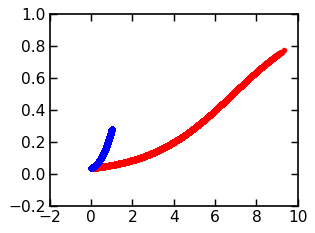

In [120]:
plt.figure(1, figsize=(4, 3))
def model(x):
    return 1 / (1 + np.exp(-x))

loss = model(D*clf.coef_ + clf.intercept_)

plt.scatter(D[:,0], loss[:,0], color='red')
plt.scatter(D[:,1], loss[:,1], color='blue')

In [126]:
clf.predict_proba(D).shape

(862086, 2)

In [121]:
plt.figure(figsize=(4,4))
prob = model((D*clf.coef_.T) + clf.intercept_)

plt.hist(prob[Y==1],bins=100, range=[0,1], alpha=0.4,
         histtype='stepfilled',lw=1, normed=1)

plt.hist(prob[Y==0],bins=100, range=[0,1], alpha=0.4,
         histtype='stepfilled',lw=1, normed=1)

plt.show()

ValueError: operands could not be broadcast together with shapes (862086,2) (2,1) 